# Lightweight python components example

This pipeline defines two simple math operation: `add` adds two input arguments and returns the sum. `my_divmod` divides two input arguments and returns the quotient and remainder. You can visit [Build Lightweight Python Components](https://www.kubeflow.org/docs/pipelines/sdk/lightweight-python-components/) for this pipeline's detail.

You can successfully run this notebook, you can see the result from `Tekton` UI. You can follow [tekton dashboard](https://github.com/tektoncd/dashboard#accessing-the-dashboard) to install the `Tekton` UI. 

Here are some screenshots to show this pipeline example and result.

Tekton resources to show the Pipelines, PipelineRuns, TaskRuns
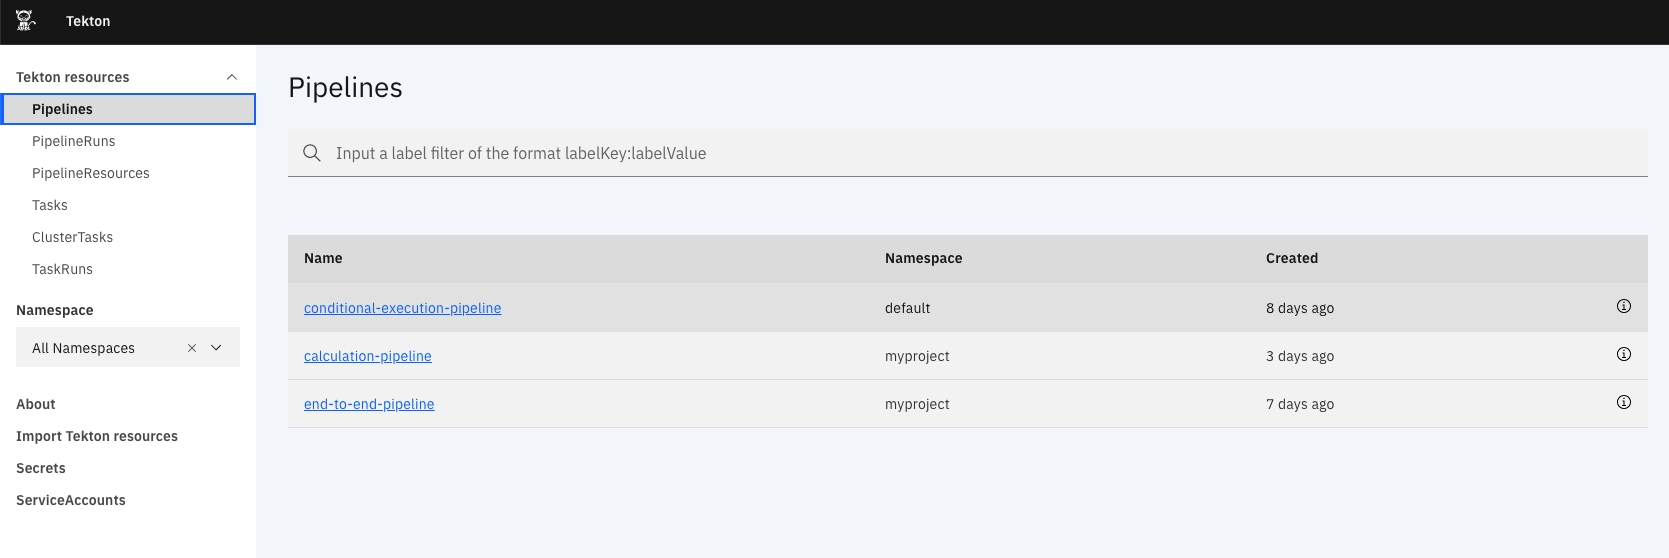
Tekton taskruns
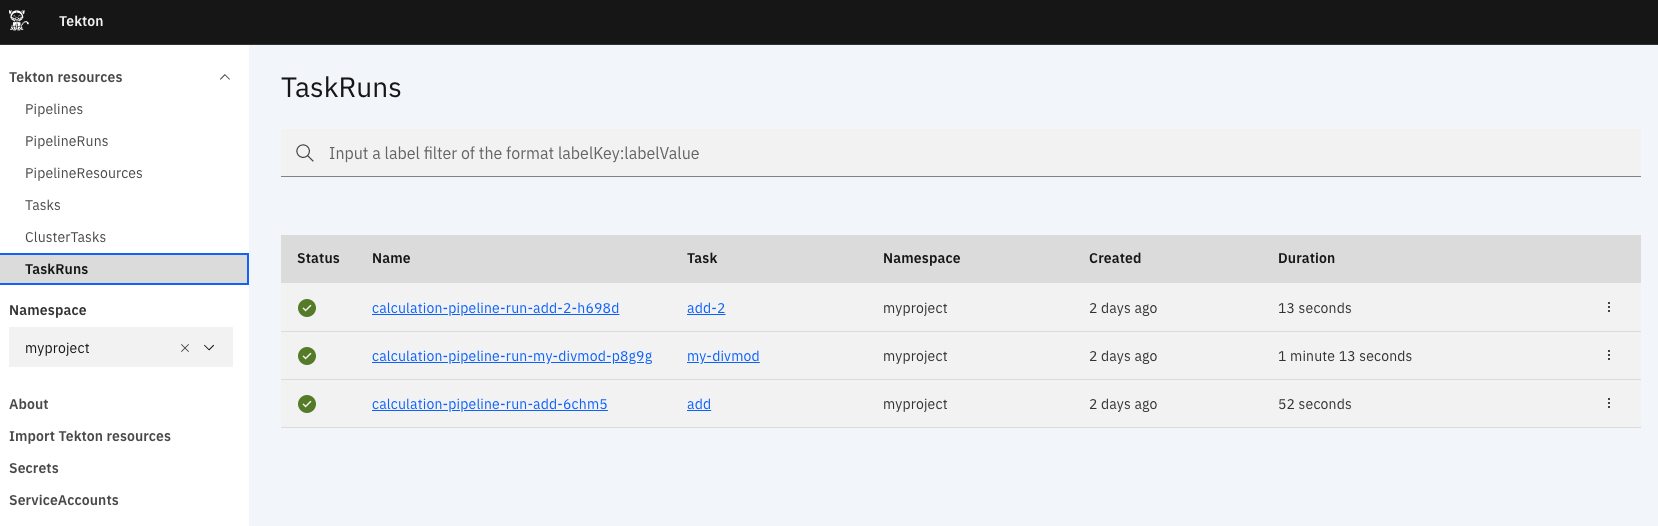
Tekton task add-2 result
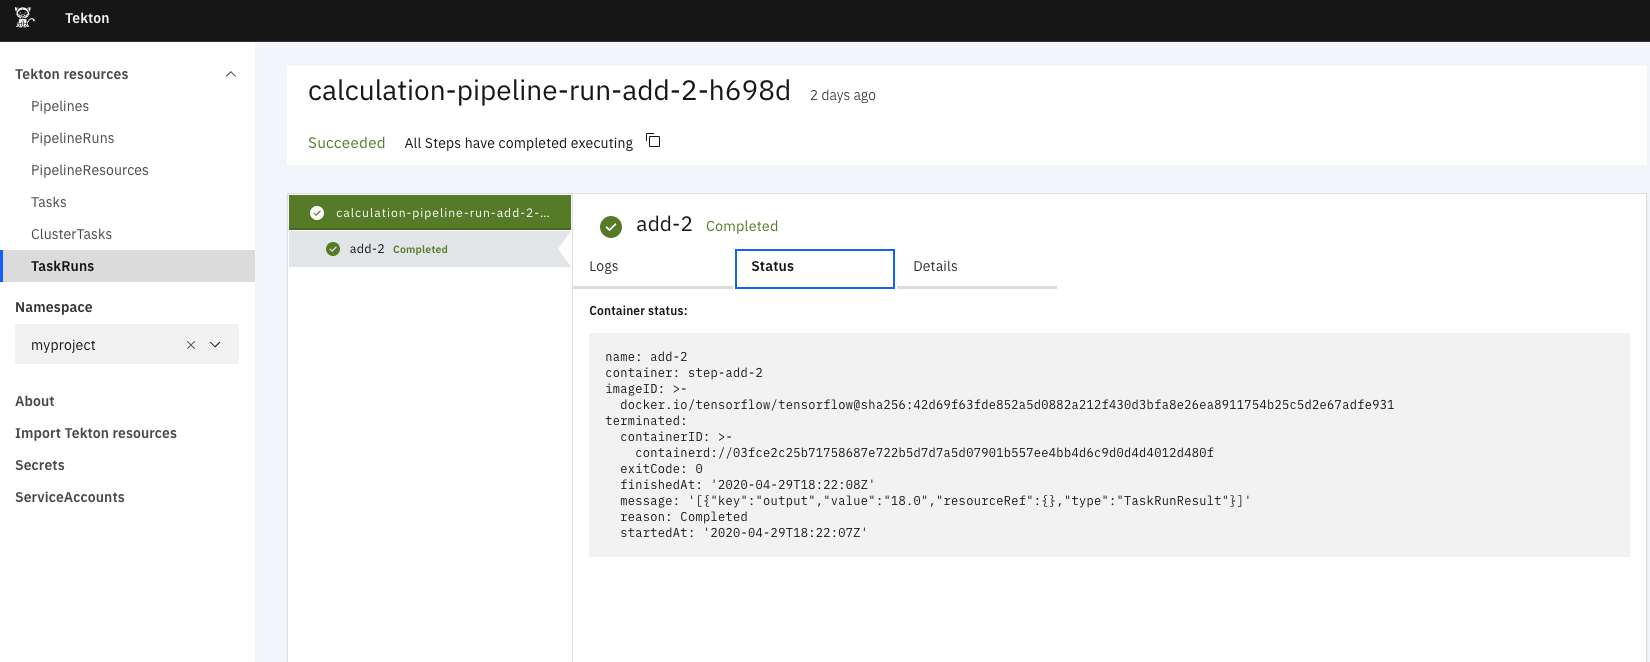
Tekton task divmod result
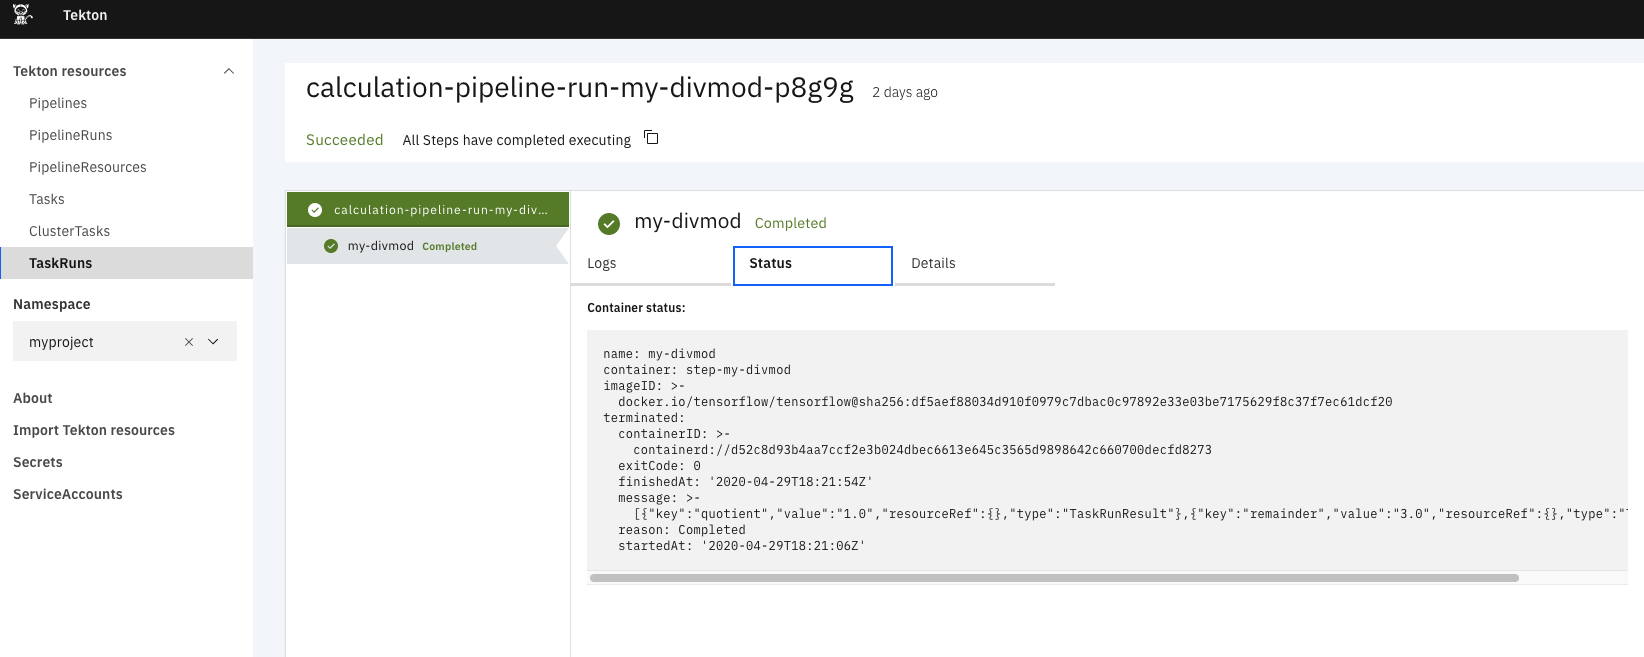
Tekton task add result
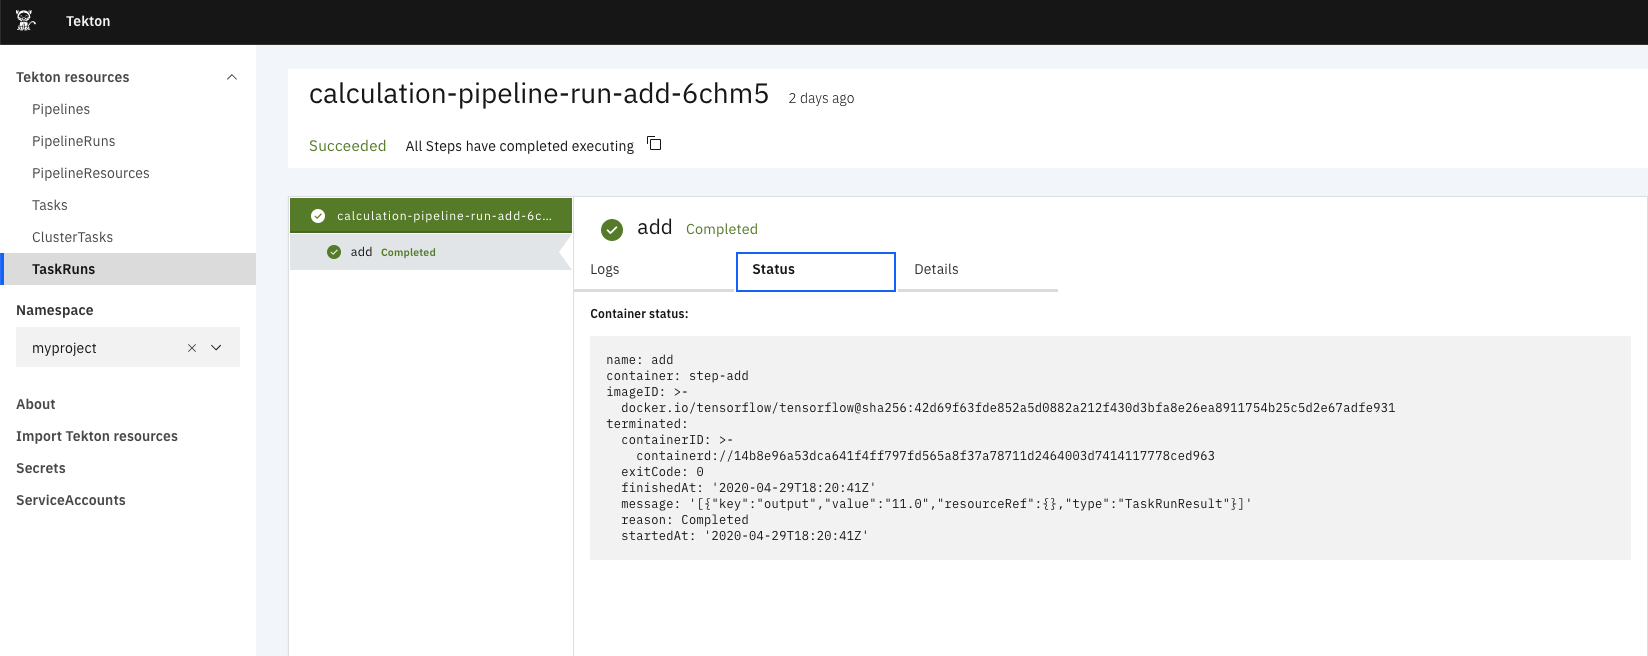

In [ ]:
pipeline_name = "lightweight-python-demo"
user_namespace = "myproject"

In [ ]:
# Install the SDK
!pip install --upgrade pip
!pip3 install 'kfp>=0.1.31.2' --quiet

In [ ]:
import kfp
import kfp.components as comp

Simple function that just add two numbers:

In [ ]:
#Define a Python function
def add(a: float, b: float) -> float:
   '''Calculates sum of two arguments'''
   return a + b

Convert the function to a pipeline operation

In [ ]:
add_op = comp.func_to_container_op(add)

A bit more advanced function which demonstrates how to use imports, helper functions and produce multiple outputs.

In [ ]:
#Advanced function
#Demonstrates imports, helper functions and multiple outputs
from typing import NamedTuple
def my_divmod(dividend: float, divisor:float) -> NamedTuple('MyDivmodOutput', [('quotient', float), ('remainder', float), ('mlpipeline_ui_metadata', 'UI_metadata'), ('mlpipeline_metrics', 'Metrics')]):
    '''Divides two numbers and calculate  the quotient and remainder'''
    #Pip installs inside a component function.
    #NOTE: installs should be placed right at the beginning to avoid upgrading a package
    # after it has already been imported and cached by python
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'tensorflow==1.8.0'])
    
    #Imports inside a component function:
    import numpy as np

    #This function demonstrates how to use nested functions inside a component function:
    def divmod_helper(dividend, divisor):
        return np.divmod(dividend, divisor)

    (quotient, remainder) = divmod_helper(dividend, divisor)

    from tensorflow.python.lib.io import file_io
    import json
    
    # Exports a sample tensorboard:
    metadata = {
      'outputs' : [{
        'type': 'tensorboard',
        'source': 'gs://ml-pipeline-dataset/tensorboard-train',
      }]
    }

    # Exports two sample metrics:
    metrics = {
      'metrics': [{
          'name': 'quotient',
          'numberValue':  float(quotient),
        },{
          'name': 'remainder',
          'numberValue':  float(remainder),
        }]}

    from collections import namedtuple
    divmod_output = namedtuple('MyDivmodOutput', ['quotient', 'remainder', 'mlpipeline_ui_metadata', 'mlpipeline_metrics'])
    return divmod_output(quotient, remainder, json.dumps(metadata), json.dumps(metrics))

Test running the python function directly

In [ ]:
my_divmod(100, 7)

#### Convert the function to a pipeline operation

You can specify an alternative base container image (the image needs to have Python 3.5+ installed).

In [ ]:
divmod_op = comp.func_to_container_op(my_divmod, base_image='tensorflow/tensorflow:1.11.0-py3')

#### Define the pipeline
Pipeline function has to be decorated with the `@dsl.pipeline` decorator

In [ ]:
import kfp.dsl as dsl
@dsl.pipeline(
   name='Calculation pipeline',
   description='A toy pipeline that performs arithmetic calculations.'
)
# Currently kfp-tekton doesn't support pass parameter to the pipelinerun yet, so we hard code the number here
def calc_pipeline(
   name=pipeline_name,
   namespace=user_namespace, 
   a='7',
   b='8',
   c='17',
):
    #Passing pipeline parameter and a constant value as operation arguments
    add_task = add_op(a, 4) #Returns a dsl.ContainerOp class instance. 
    
    #Passing a task output reference as operation arguments
    #For an operation with a single return value, the output reference can be accessed using `task.output` or `task.outputs['output_name']` syntax
    divmod_task = divmod_op(add_task.output, b)

    #For an operation with a multiple return values, the output references can be accessed using `task.outputs['output_name']` syntax
    result_task = add_op(divmod_task.outputs['quotient'], c)

In [ ]:
# !kubectl delete pipelinerun calculation-pipeline-run -n $user_namespace

Compile the pipeline into Tekton yaml using kfp-tekton SDK

In [ ]:
from kfp_tekton.compiler import TektonCompiler
TektonCompiler().compile(calc_pipeline, 'calc.yaml', generate_pipelinerun=True)

Assign permission to Tekton's default service account and run this pipeline

In [ ]:
!kubectl create clusterrolebinding $user_namespace-edit --clusterrole kubeflow-edit --serviceaccount=$user_namespace:default
!kubectl apply -f calc.yaml -n $user_namespace

Stream the pipeline logs

In [ ]:
!tkn pipelinerun logs calculation-pipeline-run -n $user_namespace -f

When the pipelinerun is done, you can descibe the pipelinerun to check the status.

In [ ]:
!tkn pipelinerun describe calculation-pipeline-run -n $user_namespace